In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from nca.constsants import SOIL_TYPES, CHANNELS, NUM_CHANNELS, PLANT_RULES, PLANT_GROUPS
from nca.suitability import compute_suitability
from nca.generate_map import generate_training_world
from nca.nca_model import NCA, get_species_features_tensor
import random


H, W = 64, 64
device = 'cuda' if torch.cuda.is_available() else 'cpu' #cuda
print("using device " + device)
# --- Grid Initialization ---

grid, variety_idx = generate_training_world(H, W,seed_plants=False)

sample_species_features = get_species_features_tensor()
model = NCA(NUM_CHANNELS, sample_species_features.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)



16NUMCHANNELS
using device cuda


In [2]:
#### TRAIN ####

from nca.nca_model import compute_loss, rollout_training_step, randomize_species_order, get_species_features_tensor, build_channel_mapping_from_species_list
import time
for epoch in range(200):
    species_list = random.sample(list(PLANT_RULES.keys()), k=10)
    species_features = get_species_features_tensor(species_list=species_list)
    build_channel_mapping_from_species_list(species_list)  
    print(CHANNELS)
    start = time.time()
    grid, variety_idx = generate_training_world(H, W, seed_plants=True, seed_smart=False)
    grid.requires_grad = True
    grid, species_features, coverage_deltas = rollout_training_step(model, grid, species_features, steps=120)
    loss = compute_loss(grid, species_features, epoch, coverage_deltas)
    print(loss)
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    if epoch % 10 == 0:
        print(f"[{epoch}] Loss: {loss.item():.4f}")

{'soil': {'loam': 0, 'clay': 1, 'sand': 2, 'peat': 3}, 'elevation': 4, 'shade': 5, 'plants': [('tree_1', 6), ('shrub_1', 7), ('tree_4', 8), ('shrub_4', 9), ('tree_0', 10), ('shrub_3', 11), ('shrub_0', 12), ('tree_5', 13), ('grass_3', 14), ('bad', 15)]}


c:\Users\schro\Documents\dev\python-habitat-sim\nca\nca_model.py:182: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clean_deltas = [d for d in coverage_deltas if not torch.isnan(torch.tensor(d)) and not torch.isinf(torch.tensor(d))]


tensor(-2.1350, device='cuda:0', grad_fn=<SubBackward0>)
[0] Loss: -2.1350
{'soil': {'loam': 0, 'clay': 1, 'sand': 2, 'peat': 3}, 'elevation': 4, 'shade': 5, 'plants': [('shrub_5', 6), ('tree_2', 7), ('tree_3', 8), ('tree_0', 9), ('shrub_0', 10), ('tree_1', 11), ('shrub_4', 12), ('grass_3', 13), ('bad', 14), ('tree_5', 15)]}
tensor(-7.7518, device='cuda:0', grad_fn=<SubBackward0>)
{'soil': {'loam': 0, 'clay': 1, 'sand': 2, 'peat': 3}, 'elevation': 4, 'shade': 5, 'plants': [('tree_3', 6), ('tree_0', 7), ('grass_2', 8), ('shrub_1', 9), ('grass_1', 10), ('tree_2', 11), ('grass_0', 12), ('grass_3', 13), ('tree_1', 14), ('tree_5', 15)]}
tensor(-11.0456, device='cuda:0', grad_fn=<SubBackward0>)
{'soil': {'loam': 0, 'clay': 1, 'sand': 2, 'peat': 3}, 'elevation': 4, 'shade': 5, 'plants': [('grass_0', 6), ('shrub_0', 7), ('grass_2', 8), ('shrub_3', 9), ('tree_5', 10), ('grass_1', 11), ('shrub_1', 12), ('bad', 13), ('tree_2', 14), ('shrub_4', 15)]}
tensor(-7.4574, device='cuda:0', grad_fn=<SubBa

In [8]:
import numpy as np

def log_channel_sums(grid: torch.Tensor):
    assert grid.ndim == 4, "Expected shape [1, channels, height, width]"
    channels = grid.shape[1]
    for c in range(channels):
        channel_sum = grid[0, c].sum().item()
        print(f"Channel {c} sum: {channel_sum}")


log_channel_sums(test_grid)

Channel 0 sum: 2104.0
Channel 1 sum: 757.0
Channel 2 sum: 846.0
Channel 3 sum: 389.0
Channel 4 sum: 379.2241516113281
Channel 5 sum: 0.0
Channel 6 sum: 3.0
Channel 7 sum: 3.0
Channel 8 sum: 3.0
Channel 9 sum: 3.0
Channel 10 sum: 3.0
Channel 11 sum: 3.0
Channel 12 sum: 3.0
Channel 13 sum: 3.0
Channel 14 sum: 3.0
Channel 15 sum: 3.0


In [4]:
#### VISUALIZE ####
from nca.nca_model import compute_loss, rollout_training_step, randomize_species_order, get_species_features_tensor, build_channel_mapping_from_species_list
from nca.animate import animate_full_ecosystem
model.eval()
species_list = random.sample(list(PLANT_RULES.keys()), k=10)
species_features = get_species_features_tensor(species_list=species_list)
build_channel_mapping_from_species_list(species_list)  
test_grid, variety_idx = generate_training_world(H, W, seed_plants=True, species_list=species_list)
elevation_static = test_grid[:, CHANNELS["elevation"]].clone().detach()
shade_static = test_grid[:, CHANNELS["shade"]].clone().detach()
soil_static = {
    idx: test_grid[:, idx].clone().detach()
    for idx in CHANNELS["soil"].values()
}

ani = animate_full_ecosystem(model, test_grid.clone(), elevation_static, soil_static, shade_static, steps=120)
from IPython.display import HTML
HTML(ani.to_jshtml())

RuntimeError: invalid multinomial distribution (sum of probabilities <= 0)

In [7]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, "nca2.pth")

In [11]:
CHANNELS['plants']

[('shrub_1', 6),
 ('shrub_5', 7),
 ('shrub_4', 8),
 ('grass_2', 9),
 ('grass_0', 10),
 ('grass_3', 11),
 ('tree_2', 12),
 ('tree_5', 13),
 ('tree_4', 14),
 ('tree_0', 15)]

In [3]:
checkpoint = torch.load("./models/nca2.pth", map_location="cpu")  # Force loading on CPU
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

NCA(
  (model): Sequential(
    (0): Conv2d(33, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [1]:
import torch
from torch.onnx import export as onnx_export  # torch >= 2.1
from nca.nca_model import NCA
from nca.constsants import NUM_CHANNELS, H, W, CHANNELS
import random
from nca.constsants import SOIL_TYPES, CHANNELS, NUM_CHANNELS, PLANT_RULES, PLANT_GROUPS
from nca.suitability import compute_suitability
from nca.generate_map import generate_training_world
from nca.nca_model import NCA, get_species_features_tensor, build_channel_mapping_from_species_list

# --- Config ---
feature_dim = 17
num_species = len(CHANNELS["plants"])

# --- Load model ---
model = NCA(base_channels=NUM_CHANNELS, feature_dim=feature_dim)
checkpoint = torch.load("./models/nca2.pth", map_location="cpu")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
# Generate test inputs just like during training
species_list = random.sample(list(PLANT_RULES.keys()), k=10)
species_features = get_species_features_tensor(species_list=species_list)
build_channel_mapping_from_species_list(species_list)

grid, _ = generate_training_world(H, W, seed_plants=True, seed_smart=False)
if grid.dim() == 3:
    grid = grid.unsqueeze(0)  # [1, C, H, W]

# Set model to eval
model.eval()

# Export using the real test inputs
torch.onnx.export(
    model,
    args=(grid.cpu(), species_features.cpu()),
    f="nca_model.onnx",
    input_names=["grid", "species_features"],
    output_names=["updated_grid"],
    opset_version=17,
    export_params=True,
    do_constant_folding=True,
    dynamic_axes={
        "grid": {0: "batch_size", 2: "height", 3: "width"},
        "species_features": {0: "species_count"},
        "updated_grid": {0: "batch_size", 2: "height", 3: "width"},
    }
)



16NUMCHANNELS


c:\Users\schro\Documents\dev\python-habitat-sim\nca\nca_model.py:24: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  valid_plants = [(plant, idx) for plant, idx in all_plants if idx < C]
c:\Users\schro\Documents\dev\python-habitat-sim\nca\nca_model.py:65: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if group_vector[group_id] == 1.0:


Channel mapping: {'soil': {'loam': 0, 'clay': 1, 'sand': 2, 'peat': 3}, 'elevation': 4, 'shade': 5, 'plants': [('shrub_1', 6), ('shrub_2', 7), ('tree_5', 8), ('shrub_5', 9), ('tree_2', 10), ('grass_2', 11), ('shrub_3', 12), ('grass_0', 13), ('tree_0', 14), ('grass_3', 15)]}
Max difference: 1.4237107038497925
Mean difference: 0.2228923887014389


<bound method Axes.set of <Axes: >>

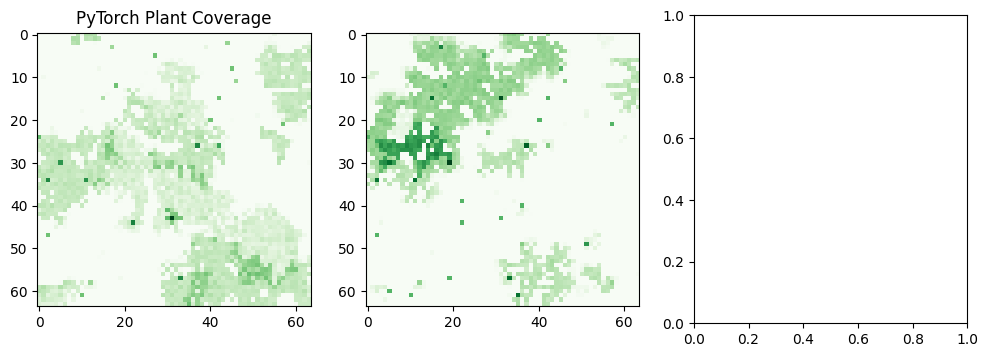

In [2]:
import torch
import numpy as np
import onnxruntime as ort
import random
import matplotlib.pyplot as plt

from nca.generate_map import generate_training_world
from nca.suitability import compute_suitability
from nca.constsants import PLANT_RULES, H, W, CHANNELS, NUM_CHANNELS
from nca.nca_model import get_species_features_tensor, build_channel_mapping_from_species_list, NCA

# --- Config ---
feature_dim = 17
steps = 60

# --- Species Setup ---
species_list = random.sample(list(PLANT_RULES.keys()), k=10)
species_features = get_species_features_tensor(species_list=species_list)
build_channel_mapping_from_species_list(species_list)
print("Channel mapping:", CHANNELS)

# --- Generate World ---
grid, variety_idx = generate_training_world(H, W, seed_plants=True, seed_smart=False)
if grid.dim() == 3:
    grid = grid.unsqueeze(0)  # [C, H, W] -> [1, C, H, W]

# Clone for both models
grid_onnx = grid.clone()
grid_pth = grid.clone().cpu()
species_features = species_features.cpu()
# --- Prepare species features ---
species_np = species_features.cpu().numpy().astype(np.float32)

# --- Run ONNX ---
grid_np = grid_onnx.cpu().numpy().astype(np.float32)
onnx_session = ort.InferenceSession("nca_model.onnx")
for step in range(steps):
    outputs = onnx_session.run(["updated_grid"], {
        "grid": grid_np,
        "species_features": species_np
    })
    grid_np = outputs[0]  # [1, C, H, W]

# --- Run PyTorch ---
model = NCA(base_channels=NUM_CHANNELS, feature_dim=feature_dim)
model.load_state_dict(torch.load("./models/nca2.pth", map_location="cpu")["model_state_dict"])
model.eval()

with torch.no_grad():
    for step in range(steps):
        grid_pth = model(grid_pth, species_features)

# --- Compare ---
grid_onnx_torch = torch.tensor(grid_np)
plant_channels = [idx for _, idx in CHANNELS["plants"]]

onnx_total = grid_onnx_torch[0, plant_channels].sum(dim=0)
pth_total = grid_pth[0, plant_channels].sum(dim=0)

diff = (onnx_total - pth_total).abs()
print("Max difference:", diff.max().item())
print("Mean difference:", diff.mean().item())

# --- Optional Visualization ---
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(pth_total.numpy(), cmap="Greens")
axs[0].set_title("PyTorch Plant Coverage")

axs[1].imshow(onnx_total.numpy(), cmap="Greens")
axs[1].set


In [3]:
import onnx
onnx_model = onnx.load("nca_model.onnx")
print(onnx.helper.printable_graph(onnx_model.graph))

graph main_graph (
  %grid[FLOAT, batch_sizex16xheightxwidth]
) {
  %/Constant_output_0 = Constant[value = <Scalar Tensor []>]()
  %/Constant_1_output_0 = Constant[value = <Scalar Tensor []>]()
  %/Gather_output_0 = Gather[axis = 1](%grid, %/Constant_output_0)
  %/Gather_1_output_0 = Gather[axis = 1](%grid, %/Constant_output_0)
  %/Constant_2_output_0 = Constant[value = <Scalar Tensor []>]()
  %/Mul_output_0 = Mul(%/Gather_1_output_0, %/Constant_2_output_0)
  %/Add_output_0 = Add(%/Gather_output_0, %/Mul_output_0)
  %/Shape_output_0 = Shape(%/Gather_output_0)
  %/Expand_output_0 = Expand(%/Add_output_0, %/Shape_output_0)
  %onnx::Gather_15 = Shape(%grid)
  %onnx::Gather_16 = Constant[value = <Scalar Tensor []>]()
  %onnx::Cast_17 = Gather[axis = 0](%onnx::Gather_15, %onnx::Gather_16)
  %onnx::Range_18 = Cast[to = 7](%onnx::Cast_17)
  %onnx::Range_19 = Constant[value = <Scalar Tensor []>]()
  %onnx::Range_20 = Constant[value = <Scalar Tensor []>]()
  %onnx::Reshape_21 = Range(%onnx::Ran